# NLP - Text Classification of Coronavirus Tweets

Link: https://www.kaggle.com/competitions/sentence-classification-of-coronavirus-tweets

Competition Description

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster.
In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified. If this is your first time working on an NLP problem, we've created a quick tutorial to get you up and running.

Disclaimer: The dataset for this competition contains text that may be considered profane, vulgar, or offensive.

!pip install -q transformers
!pip install -Uq scikit-learn
!pip install -qU tensorboard

In [1]:
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Optional, Tuple

from sklearn.metrics import confusion_matrix

import torch
from torch.nn import ConstantPad1d
from torch.nn.functional import pad
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split, Dataset
from transformers import BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action="ignore")

pd.set_option('display.max_colwidth', 5000)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)

device = torch.device('cuda' if torch.cuda.is_available() else '')
device

device(type='cuda')

In [2]:
def text_preprocessing(row):
    text = row["text"] + " #" + row["keyword"] if row["keyword"] else row["text"]
    text = re.sub("@\S+", "@user", text)
    text = re.sub("https?://\S+", "<url>" , text)
    text = re.sub("\?+", "?" , text)
    text = re.sub("\.", "." , text)
    text = re.sub("!+", "!" , text)
    text = re.sub("[:;][\)\(pPD]", "!" , text)
    return text   

In [3]:
labels_mapping = {0: "false diseaster", 1: "real diseaster"}

df = pd.read_csv("data/train.csv")
df["keyword"].value_counts().tail(50)
df.fillna("", inplace=True)
df["text"] = df.apply(lambda row: text_preprocessing(row), axis=1)
df["label"] = df["target"].map(labels_mapping)
df.drop(["id", "keyword", "location"], axis=1, inplace=True)
df.head(10)

,id,keyword,location,text,target,label
0,1,,,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,real diseaster
1,4,,,Forest fire near La Ronge Sask. Canada,1,real diseaster
2,5,,,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,real diseaster
3,6,,,"13,000 people receive #wildfires evacuation orders in California",1,real diseaster
4,7,,,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,real diseaster
5,8,,,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1,real diseaster
6,10,,,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1,real diseaster
7,13,,,I'm on top of the hill and I can see a fire in the woods...,1,real diseaster
8,14,,,There's an emergency evacuation happening now in the building across the street,1,real diseaster
9,15,,,I'm afraid that the tornado is coming to our area...,1,real diseaster


# Model & Tokenizer

In [4]:
model_name_or_path = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name_or_path, do_lower_case=True)
tokenizer.special_tokens_map

{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

# Dataset

In [5]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer):
        super().__init__()
        self.tokenizer = tokenizer
        self.inputs = df["text"].values
        self.labels = torch.tensor(df["target"].values).to(torch.int64)

    def __getitem__(self, idx):
        encoded_dict = tokenizer(self.inputs[idx],
                                 add_special_tokens = True,
                                 return_attention_mask = True,
                                 return_tensors = 'pt',
                   )
        return encoded_dict['input_ids'][0], encoded_dict['token_type_ids'][0], encoded_dict['attention_mask'][0], self.labels[idx]

    def __len__(self):
        return len(self.labels)

In [6]:
dataset = CustomDataset(df, tokenizer)
train_size = int(0.8 * len(dataset))
validation_size = len(dataset)  - train_size
train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(validation_size))


6,090 training samples
1,523 validation samples


# Dataloaders

In [7]:
def padding_function(x, max_len):
    return ConstantPad1d((0, max_len - len(x)), 0)(x)

def collate_fn(batch):
    max_len = max([len(sample[0]) for sample in batch])
    ids = torch.stack([padding_function(sample[0], max_len) for sample in batch])
    token_types = torch.stack([padding_function(sample[1], max_len) for sample in batch])
    attention_masks = torch.stack([padding_function(sample[2], max_len) for sample in batch])
    labels = torch.tensor([sample[3] for sample in batch])
    return ids, token_types, attention_masks, labels


In [8]:
batch_size = 32

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size,
            collate_fn=collate_fn
        )

validation_dataloader = DataLoader(
            validation_dataset,
            sampler = SequentialSampler(validation_dataset),
            batch_size = batch_size,
            collate_fn=collate_fn
        )

# Model

In [9]:
class ClassificationModel(LightningModule):

    def __init__(
        self,
        model_name_or_path: str,
        num_labels: int,
        learning_rate: float = 2e-5,
        adam_epsilon: float = 1e-8,
        warmup_steps: int = 0,
        weight_decay: float = 0.0,
    ):
        super().__init__()
        self.save_hyperparameters()
        self.larning_rate = learning_rate
        self.adam_epsilon = adam_epsilon
        self.weight_decay = weight_decay
       
        self.training_step_outputs = []
        self.validation_step_outputs = []

        self.model = BertForSequenceClassification.from_pretrained(model_name_or_path,
                                                           num_labels = num_labels,
                                                           output_attentions = False,
                                                           output_hidden_states = False)

    def forward(self, **inputs):
        return self.model(**inputs)

    def training_step(self, batch, batch_idx):
        outputs = self.model(input_ids=batch[0],
                       token_type_ids=batch[1],
                       attention_mask=batch[2],
                       labels=batch[3])
        return outputs.loss


    def validation_step(
        self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int
    ) -> torch.Tensor:

        outputs = self.model(input_ids=batch[0],
                       token_type_ids=batch[1],
                       attention_mask=batch[2],
                       labels=batch[3])
        
        predictions = torch.argmax(outputs.logits, axis=1)
        labels = batch[3]
        self.validation_step_outputs.append({"loss": outputs.loss, "predictions": predictions, "labels": batch[3]})
     

    def on_validation_epoch_end(self):
        outputs = self.validation_step_outputs
        predictions = torch.cat([x["predictions"] for x in outputs]).detach().cpu().numpy()
        labels = torch.cat([x["labels"] for x in outputs]).detach().cpu().numpy()
        loss = torch.stack([x["loss"] for x in outputs]).mean()
        self.log("validation_loss", loss, prog_bar=True)
        self.log("validation_accuracy", (labels==predictions).sum()/len(predictions), prog_bar=True)
        self.validation_step_outputs.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.larning_rate, eps=self.adam_epsilon)
        return [optimizer]

    def save_model(self, savefile):
        self.model.save_pretrained(savefile)
      

# Tuning

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 2.830989119762725e-05
Restoring states from the checkpoint path at /home/neofelia/Desktop/kaggle/Text Classification of Coronavirus Tweets/.lr_find_380630bd-ac09-4803-a4c8-177d7146878b.ckpt
Restored all states from the checkpoint at /home/neofelia/Desktop/kaggle/Text Classification of Coronavirus Tweets/.lr_find_380630bd-ac09-4803-a4c8-177d7146878b.ckpt


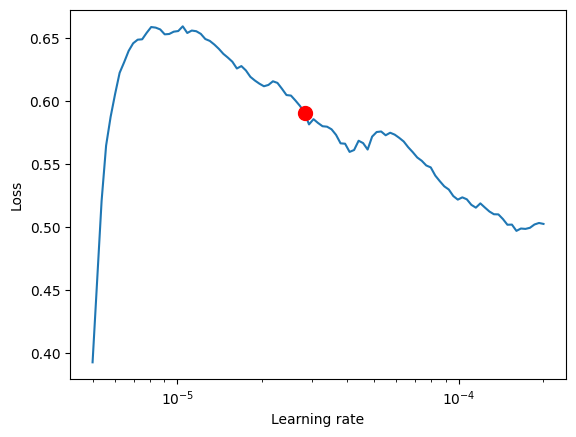

In [10]:
from pytorch_lightning.tuner import Tuner

epochs = 3
learning_rate = 1e-5
adam_epsilon = 1e-7
num_labels=2

model = ClassificationModel(model_name_or_path, num_labels, learning_rate, adam_epsilon)
trainer = Trainer(accelerator="cpu", max_epochs=epochs)

tuner = Tuner(trainer)
lr_finder = tuner.lr_find(model, 
                          attr_name="larning_rate",
                          train_dataloaders=train_dataloader,
                          val_dataloaders=validation_dataloader,
                          min_lr=5e-6,
                          max_lr=2e-4,
                          early_stop_threshold=None
                        )

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Training

In [31]:
from lightning.pytorch.loggers import TensorBoardLogger

epochs = 3
learning_rate = 8e-5
adam_epsilon = 1e-7

early_stopping = EarlyStopping(monitor="validation_loss", mode="min", patience=1)
logger = TensorBoardLogger("tb_logs", name="ner_model")

model = ClassificationModel(model_name_or_path, num_labels, learning_rate, adam_epsilon)
trainer = Trainer(accelerator="cpu", max_epochs=epochs, callbacks=[early_stopping], logger=logger)
trainer.fit(model, train_dataloader, validation_dataloader)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type                          | Params
--------------------------------------------------------
0 | model | BertForSequenceClassification | 109 M 
--------------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.935   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


# Evaluate

In [33]:
def evaluate(dataloader):

    true_labels = []
    predicted_labels = []
    language = []

    for i, batch in enumerate(dataloader):

        output = model(input_ids=batch[0],
                          token_type_ids=batch[1],
                          attention_mask=batch[2],
                          labels=batch[3])
        true_labels.append(batch[3].to('cpu').numpy())

        predicted_labels.append(torch.argmax(output.logits.detach().cpu(), 1).numpy())

    true_labels = np.concatenate(true_labels, axis=0)
    predicted_labels = np.concatenate(predicted_labels, axis=0)

    accuracy = sum(true_labels==predicted_labels)/len(true_labels)
    print("accuracy", accuracy)

    cm = confusion_matrix(true_labels, predicted_labels, labels=[0,1], normalize='true')
    ax= plt.subplot()
    sns.heatmap(np.round(cm, 2), annot=True, fmt='g', ax=ax, cmap='cool')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(["false diseaster", "true diseaster"])
    ax.yaxis.set_ticklabels(["false diseaster", "true diseaster"])
    plt.show()



accuracy 0.9371100164203613


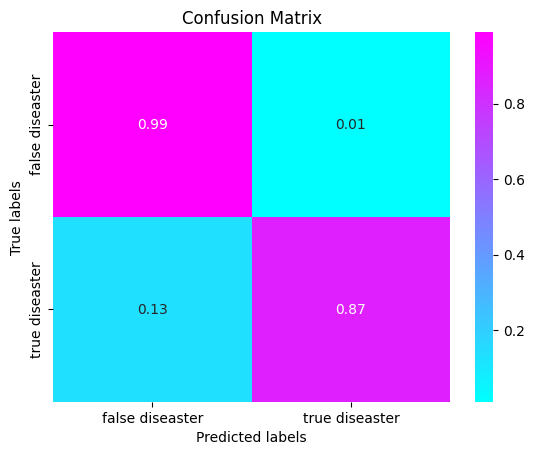

In [34]:
evaluate(train_dataloader)

accuracy 0.8299409061063691


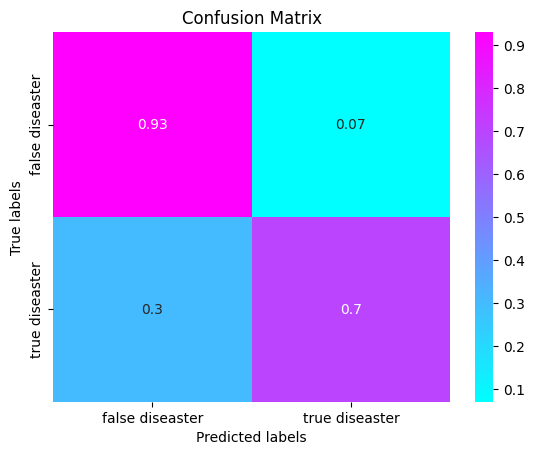

In [35]:
evaluate(validation_dataloader)

# Save pretrained model

In [36]:
model.save_model("classification_model")
tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/vocab.txt',
 'tokenizer/added_tokens.json')

# Predict

In [37]:
from torch.nn import functional as F

def predict(raw_text, serialized=True):

    inputs = tokenizer(raw_text,
                       add_special_tokens = True,
                       return_attention_mask = True,
                       return_tensors = 'pt',
                   )
    outputs = F.softmax(model(**inputs).logits).detach().cpu()
    outputs = torch.max(outputs, 1)
    score = round(float(outputs.values[0]), 3)
    predicted_label = labels_mapping[int(outputs.indices[0])]

    if serialized:
        return predicted_label, score
    return {"text": raw_text, "predicted_label": predicted_label, "score": score}

In [38]:
df["predicted_label"], df["score"] = zip(*df['text'].map(predict))
df.head()

,id,keyword,location,text,target,label,predicted_label,score
0,1,,,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,real diseaster,real diseaster,0.768
1,4,,,Forest fire near La Ronge Sask. Canada,1,real diseaster,real diseaster,0.993
2,5,,,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,real diseaster,real diseaster,0.992
3,6,,,"13,000 people receive #wildfires evacuation orders in California",1,real diseaster,real diseaster,0.992
4,7,,,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,real diseaster,real diseaster,0.966


In [39]:
predict("Hello! I am on fire", serialized=False)

{'text': 'Hello! I am on fire',
 'predicted_label': 'false diseaster',
 'score': 0.931}

In [40]:
example = input()
predict(example, serialized=False)

 There is flood in northen part of the city. All citizents are required to leave the place


{'text': 'There is flood in northen part of the city. All citizents are required to leave the place',
 'predicted_label': 'real diseaster',
 'score': 0.992}